In [ ]:
!pip install gymnasium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 8.1 MB/s eta 0:00:00


In [ ]:
import gymnasium as gym
import random
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
class WeatherEnv(gym.Env):
    def __init__(self):
        super(WeatherEnv, self).__init__()
        # Action space: [Accessory (3 options), Clothing (3 options)]
        self.action_space = gym.spaces.MultiDiscrete(
            [3, 3]
        )  # 0: Umbrella, 1: Snow Boots, 2: Sunscreen for accessory; Warm, Medium, Summer for clothing

        # State space: 7 days of temperature and weather conditions
        self.observation_space = gym.spaces.Dict(
            {
                "temperature": gym.spaces.Box(
                    low=-50, high=120, shape=(7,), dtype=float
                ),
                "conditions": gym.spaces.MultiDiscrete(
                    [3] * 7
                ),  # 0: Snow, 1: Rain, 2: Sunny
            }
        )

    def reset(self, seed=None, options=None):
        super().reset(seed=seed, options=options)
        temperatures = [random.uniform(-50, 120) for _ in range(7)]
        conditions = [random.randint(0, 2) for _ in range(7)]

        # Adjust conditions based on temperatures
        # no snow if temperature is above 50
        conditions = [
            1
            if temp > 50 and condition == 0
            else 0
            if temp < 32 and condition == 1
            else condition
            for temp, condition in zip(temperatures, conditions)
        ]

        self.state = {"temperature": temperatures, "conditions": conditions}
        return self.state, {}

    def step(self, action):
        correct_decisions = self._decide_optimal_choices(self.state)
        reward = sum([50 if action[i] == correct_decisions[i] else 0 for i in range(2)])
        done = True
        return self.state, reward, done, done, {}

    def _decide_optimal_choices(self, state):
        # Determine the ideal accessory based on the most common weather condition
        most_common_condition = max(
            set(state["conditions"]), key=state["conditions"].count
        )
        accessory_choice = self._decide_accessory(most_common_condition)

        # Determine the ideal clothing based on the average temperature
        average_temp = np.mean(state["temperature"])
        clothing_choice = self._decide_clothing(average_temp)

        return [accessory_choice, clothing_choice]

    def _decide_accessory(self, weather_condition):
        # 0: Umbrella for Rain, 1: Snow Boots for Snow, 2: Sunscreen for Sunny
        if weather_condition == 1:  # Rain
            # print("Umbrella")
            return 0
        elif weather_condition == 0:  # Snow
            # print("Snow Boots")
            return 1
        else:  # Sunny
            # print("Sunscreen")
            return 2

    def _decide_clothing(self, average_temp):
        # 0: Warm, 1: Medium, 2: Summer
        if average_temp < 32:  # B1elow freezing
            # print("Warm")
            return 0
        elif 32 <= average_temp < 70:  # Moderate
            # print("Medium")
            return 1
        else:  # Warm
            # print("Summer")
            return 2

    def render(self, mode="human"):
        print(f"Current State: {self.state}")


def generate_prompt(state):
    # Adjust conditions based on temperature
    adjusted_conditions = [
        "Snow" if condition == 0 else "Rain" if condition == 1 else "Sunny"
        for temp, condition in zip(state["temperature"], state["conditions"])
    ]

    # Create the prompt
    prompt = (
        f"Consider the following data about weather conditions for the last 7 days:\n\n"
    )
    prompt += f"- Temperatures (in °F): {state['temperature']}\n"
    prompt += f"- Weather Conditions: {adjusted_conditions}\n\n"
    prompt += "Rules:\n"
    prompt += "1. If the temperature is above 50°F, it cannot be snowing. In such cases, snow should be replaced with rain.\n"
    prompt += (
        "2. The ideal accessory choice depends on the most common weather condition:\n"
    )
    prompt += "   - If it's mostly sunny, pick 'Sunscreen'.\n"
    prompt += "   - If it's mostly raining, pick 'Umbrella'.\n"
    prompt += "   - If it's mostly snowing, pick 'Snow Boots'.\n"
    prompt += "3. The ideal clothing choice depends on the average temperature:\n"
    prompt += "   - Below 32°F: 'Warm' clothing.\n"
    prompt += "   - Between 32°F and 70°F: 'Medium' clothing.\n"
    prompt += "   - Above 70°F: 'Summer' clothing.\n\n"
    prompt += "Based on the above data and rules, what should be the ideal accessory and clothing choice? Please explain your reasoning.\n"

    return prompt


if __name__ == "__main__":
    env = WeatherEnv()
    for _ in range(5):  # Run 5 test cases
        state = env.reset()
        print(f"Initial State: {state}")
        action = env.action_space.sample()  # Random action
        next_state, reward, done, _, info = env.step(action)
        print(f"State: {state}, Action: {action}, Reward: {reward}, Done: {done}")
        print("\n\n")
        # print(generate_prompt(state))


Initial State: ({'temperature': [-10.124768297242397, 47.46152950501228, -16.215222207433392, -28.35745679898973, 88.23781025613525, 80.80338776759811, 67.79088785952322], 'conditions': [0, 1, 0, 2, 2, 1, 2]}, {})
State: ({'temperature': [-10.124768297242397, 47.46152950501228, -16.215222207433392, -28.35745679898973, 88.23781025613525, 80.80338776759811, 67.79088785952322], 'conditions': [0, 1, 0, 2, 2, 1, 2]}, {}), Action: [2 2], Reward: 50, Done: True



Initial State: ({'temperature': [92.04516599717553, 116.57562878615585, -20.076683398328576, 40.03535864571866, 75.03567644538715, 84.06793045628658, -48.41964410651844], 'conditions': [2, 2, 2, 2, 2, 2, 2]}, {})
State: ({'temperature': [92.04516599717553, 116.57562878615585, -20.076683398328576, 40.03535864571866, 75.03567644538715, 84.06793045628658, -48.41964410651844], 'conditions': [2, 2, 2, 2, 2, 2, 2]}, {}), Action: [1 2], Reward: 0, Done: True



Initial State: ({'temperature': [28.30296736737698, -11.577054162802277, 41.889

In [ ]:
class WeatherAgent:
    def __init__(
        self,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95,
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            discount_factor: The discount factor for computing the Q-value
        """
        self.q_values = defaultdict(lambda: np.zeros((3, 3)))  # Accessory, Clothing

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.training_error = []

    def get_action(self, obs: dict) -> np.ndarray:
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        # with probability epsilon return a random action to explore the environment
        if np.random.random() < self.epsilon:
            return np.array([np.random.randint(3), np.random.randint(3)])

        # with probability (1 - epsilon) act greedily (exploit)
        else:
            return np.unravel_index(
                np.argmax(self.q_values[(tuple(obs['temperature']), tuple(obs['conditions']))]),
                (3, 3)
            )

    def update(
        self,
        obs: dict,
        action: np.ndarray,
        reward: float,
        terminated: bool,
        next_obs: dict,
    ):
        state_key = (tuple(obs['temperature']), tuple(obs['conditions']))
        next_state_key = (tuple(next_obs['temperature']), tuple(next_obs['conditions']))

        future_q_value = 0 if terminated else np.max(self.q_values[next_state_key])
        temporal_difference = (
            reward + self.discount_factor * future_q_value - self.q_values[state_key][tuple(action)]
        )

        self.q_values[state_key][tuple(action)] += self.lr * temporal_difference
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)


In [ ]:
# hyperparameters
learning_rate = 0.01
n_episodes = 100_000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1

agent = WeatherAgent(
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

In [ ]:
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)

for episode in tqdm(range(n_episodes)):
    obs, _ = env.reset()
    done = False
    # print(obs)
    # play one episode
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, done, _, info = env.step(action)
        # update the agent
        # print(done)
        agent.update(obs, action, reward, done, next_obs)

        obs = next_obs

    agent.decay_epsilon()

100%|██████████| 100000/100000 [00:19<00:00, 5160.46it/s]


In [ ]:
rewards = []

for episode in range(1000):
    obs, info = env.reset()
    done = False
    # play one episode
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)
        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs
    rewards.append(reward)
np.mean(rewards)

34.4

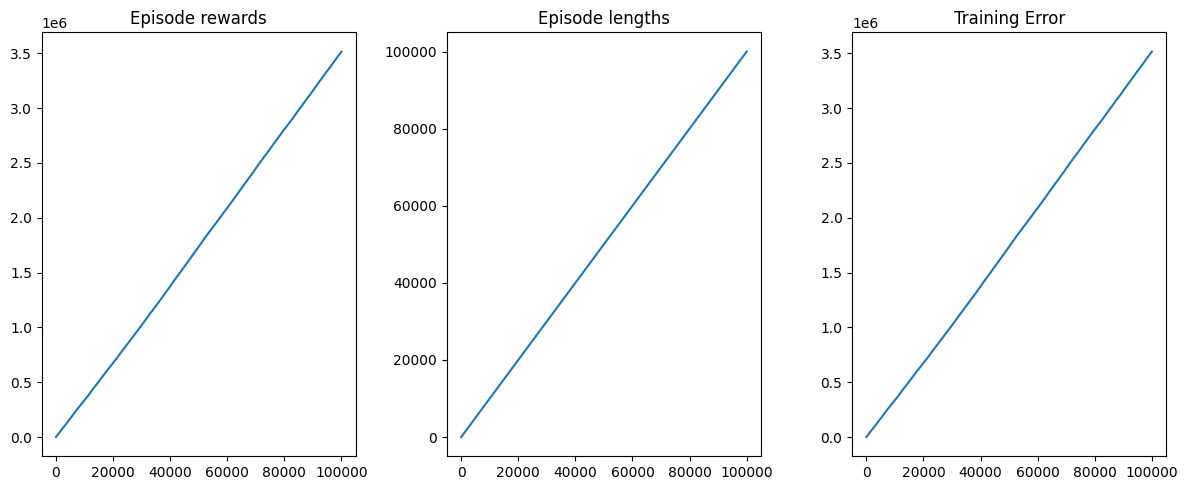

In [ ]:
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
axs[0].set_title("Episode rewards")
# Compute the cumulative sum of the data to convert from rolling average
reward_cumulative_sum = np.cumsum(np.array(env.return_queue).flatten())
axs[0].plot(range(len(reward_cumulative_sum)), reward_cumulative_sum)
# Plot other graphs similarly for cumulative sum
axs[1].set_title("Episode lengths")
length_cumulative_sum = np.cumsum(np.array(env.length_queue).flatten())
axs[1].plot(range(len(length_cumulative_sum)), length_cumulative_sum)
axs[2].set_title("Training Error")
training_error_cumulative_sum = np.cumsum(np.array(agent.training_error))
axs[2].plot(range(len(training_error_cumulative_sum)), training_error_cumulative_sum)
plt.tight_layout()
plt.show()

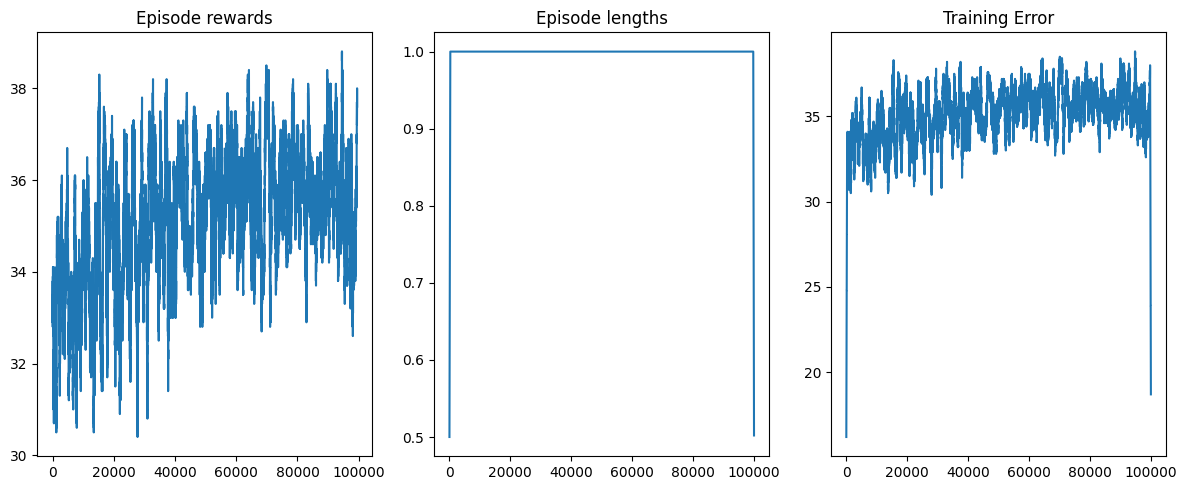

In [ ]:
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
axs[0].set_title("Episode rewards")
# compute and assign a rolling average of the data to provide a smoother graph
reward_moving_average = (
    np.convolve(
        np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[1].set_title("Episode lengths")
length_moving_average = (
    np.convolve(
        np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same"
    )
    / rolling_length
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
axs[2].set_title("Training Error")
training_error_moving_average = (
    np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same")
    / rolling_length
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
plt.tight_layout()
plt.show()